In [137]:
import glob
import os
import pandas as pd
from skimage import color, exposure, img_as_ubyte
from matplotlib import image
import matplotlib.pyplot as plt
from functions_dl import *
from skimage.filters import threshold_multiotsu
from skimage.feature import canny
from skimage.transform import resize
from skimage.io import imsave
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import cv2

---
# 1. Création du dataframe

In [100]:
# Je récupère les uri de chaque image
dogs_lst = []
for file in glob.glob('src\img\*\*.jpg'):
    dogs_lst.append(file)

# Je stocke dans un dataframe
dogs = pd.DataFrame(dogs_lst, columns=['uri'])

# Je récupère les noms de fichiers
dogs['filename'] = dogs['uri'].str.split('\\').str.get(3)

# J'extrais la race
dogs['breeds'] = dogs.uri.str.split('\\').str.get(2).str.slice(10)

# Je récupère le format de la photo
dogs['shape'] = dogs.uri.apply(lambda x: image.imread(x).shape)

# Je récupère les ratios des images
dogs['ratio'] = dogs['shape'].str.get(0) / dogs['shape'].str.get(1)

dogs

uri             filename  \
0        src\img\n02085620-Chihuahua\n02085620_10074.jpg  n02085620_10074.jpg   
1        src\img\n02085620-Chihuahua\n02085620_10131.jpg  n02085620_10131.jpg   
2        src\img\n02085620-Chihuahua\n02085620_10621.jpg  n02085620_10621.jpg   
3         src\img\n02085620-Chihuahua\n02085620_1073.jpg   n02085620_1073.jpg   
4        src\img\n02085620-Chihuahua\n02085620_10976.jpg  n02085620_10976.jpg   
...                                                  ...                  ...   
20575  src\img\n02116738-African_hunting_dog\n0211673...   n02116738_9798.jpg   
20576  src\img\n02116738-African_hunting_dog\n0211673...   n02116738_9818.jpg   
20577  src\img\n02116738-African_hunting_dog\n0211673...   n02116738_9829.jpg   
20578  src\img\n02116738-African_hunting_dog\n0211673...   n02116738_9844.jpg   
20579  src\img\n02116738-African_hunting_dog\n0211673...   n02116738_9924.jpg   

                    breeds          shape     ratio  
0                Chihuahua  (500, 333, 3)  1.501502  
1                Chihuahua  (495, 395, 3)  1.253165  
2                Chihuahua  (298, 500, 3)  0.596000  
3                Chihuahua  (500, 345, 3)  1.449275  
4                Chihuahua  (484, 322, 3)  1.503106  
...                    ...            ...       ...  
20575  African_hunting_dog  (375, 500, 3)  0.750000  
20576  African_hunting_dog  (333, 500, 3)  0.666000  
20577  African_hunting_dog  (300, 202, 3)  1.485149  
20578  African_hunting_dog  (400, 600, 3)  0.666667  
20579  African_hunting_dog  (240, 327, 3)  0.733945  

[20580 rows x 5 columns]

In [103]:
print(f'Nous avons {len(dogs)} photos de chiens comprenant {dogs.breeds.nunique()} races.')

Nous avons 20580 photos de chiens comprenant 120 races.


---
# Réduction de la taille des images

## Vérification des couches de couleurs

In [52]:
dogs['shape'].str.get(2).reset_index().groupby('shape').count()

index
shape       
3      20579
4          1

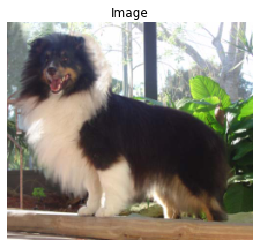

In [58]:
idx = dogs[dogs['shape'].str.get(2) == 4].index[0]
show_image(image.imread(dogs.uri[idx]))

Nous avons une image avec une couche alpha en plus du RGB. Je la retire du jeu de donnée, car théoriquement incompatible avec le format jpg.

In [98]:
dogs = dogs[dogs['shape'].str.get(2) != 4]
dogs = dogs.reset_index(drop=True)
dogs['shape'].str.get(2).reset_index().groupby('shape').count()

index
shape       
3      20579

## Vérification de la qualité

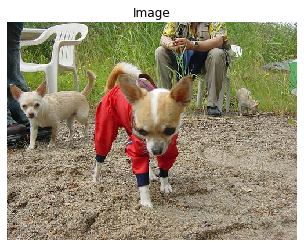

(375, 500, 3)

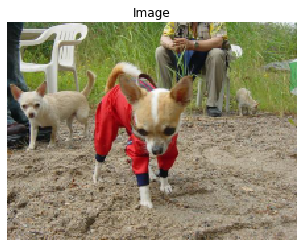

(165, 220, 3)

In [17]:
idx = 10
img = image.imread(dogs_test.uri[idx])
show_image(img)
display(img.shape)
img220 = resize_h220(img, dogs_test.ratio[idx])
show_image(img220)

display(img220.shape)

## Exécution de la réduction

In [99]:
# Exécuté 1 seule fois pour la création des images
for i in range(len(dogs)):
    path = 'src\img220\\' + dogs.breeds[i] + '\\'
    if os.path.isfile(path + dogs.filename[i]) is False:
        img = image.imread(dogs.uri[i])
        img220 = resize_h220(img, dogs.ratio[i])
        
        if os.path.isdir(path) is False:
            os.mkdir(path)
        imsave(path + dogs.filename[i], img_as_ubyte(img220))

## Vérification des transformations

In [105]:
# Je récupère les uri de chaque image
dogs220_lst = []
for file in glob.glob('src\img220\*\*.jpg'):
    dogs220_lst.append(file)

# Je stocke dans un dataframe
dogs220 = pd.DataFrame(dogs220_lst, columns=['uri'])

# J'extrais la race
dogs220['breeds'] = dogs220.uri.str.split('\\').str.get(2)

# Je récupère le format de la photo
dogs220['shape'] = dogs220.uri.apply(lambda x: image.imread(x).shape)

dogs220

uri   breeds          shape
0         src\img220\affenpinscher\n02110627_10147.jpg      her  (196, 220, 3)
1         src\img220\affenpinscher\n02110627_10185.jpg      her  (202, 220, 3)
2         src\img220\affenpinscher\n02110627_10225.jpg      her  (165, 220, 3)
3         src\img220\affenpinscher\n02110627_10437.jpg      her  (165, 220, 3)
4         src\img220\affenpinscher\n02110627_10439.jpg      her  (165, 220, 3)
...                                                ...      ...            ...
20574    src\img220\Yorkshire_terrier\n02094433_96.jpg  terrier  (176, 220, 3)
20575  src\img220\Yorkshire_terrier\n02094433_9618.jpg  terrier  (165, 220, 3)
20576   src\img220\Yorkshire_terrier\n02094433_962.jpg  terrier  (330, 220, 3)
20577   src\img220\Yorkshire_terrier\n02094433_967.jpg  terrier  (147, 220, 3)
20578  src\img220\Yorkshire_terrier\n02094433_9739.jpg  terrier  (330, 220, 3)

[20579 rows x 3 columns]

In [115]:
print(f'Nous avons {len(dogs220)} photos de chiens comprenant {dogs220.breeds.nunique()} races. Une photo a été sortie. Les réductions sont validées')

Nous avons 20579 photos de chiens comprenant 120 races. Une photo a été sortie. Les réductions sont validées


Cette opération a en moyenne réduit le poids des photos par 4. Nous économiserons du temps de calcul.

---
# Réduction du bruit

In [116]:
img = image.imread(dogs.uri.loc[100])

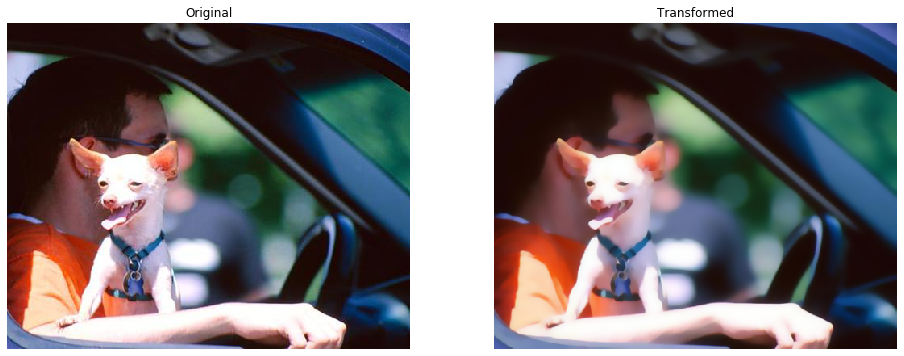

In [121]:
denoised_img = denoise_tv_chambolle(img, weight=0.1, multichannel=True)
compare_img(img, denoised_img)

---
# Colorisation

In [69]:
image.imread(dogs.uri.loc[100]).shape

(405, 500, 3)

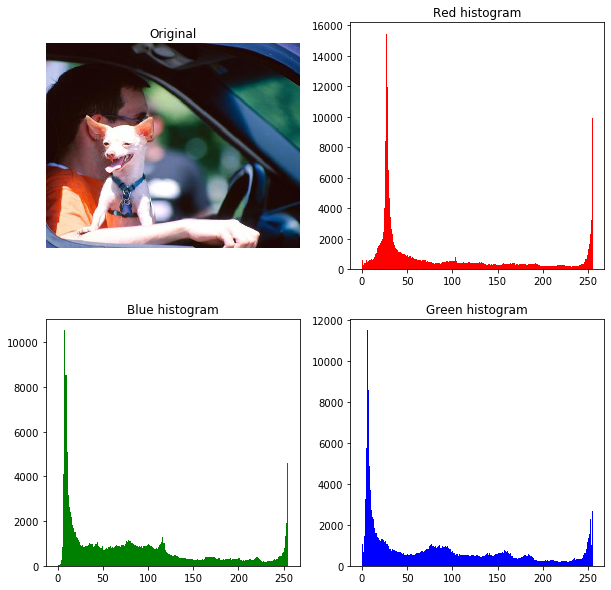

In [5]:
rgb_color(img)

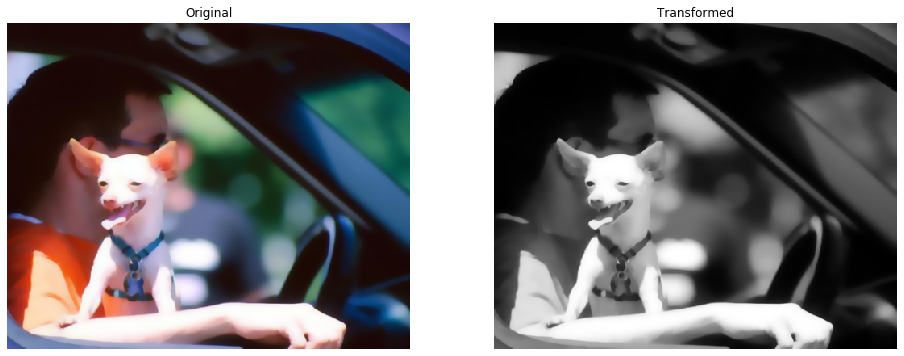

In [123]:
gray_img = color.rgb2gray(denoised_img)
compare_img(denoised_img, gray_img)

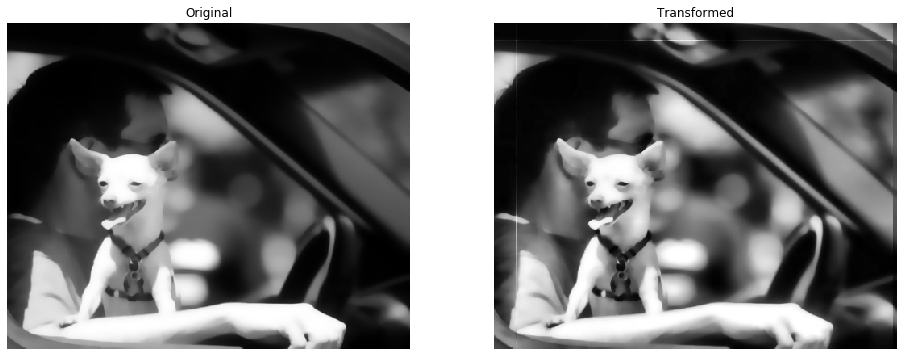

In [124]:
gray_img_eq = exposure.equalize_adapthist(gray_img)
compare_img(gray_img, gray_img_eq)

---
# SIFT

In [147]:
print(cv2.__version__)

4.2.0


In [146]:
import cv2

In [149]:
sift = cv2.xfeatures2d.SIFT_create()

error: OpenCV(4.2.0) ..\opencv_contrib\modules\xfeatures2d\src\sift.cpp:1210: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function &#39;cv::xfeatures2d::SIFT::create&#39;


In [140]:

key, desc = sift.detectAndCompute(gray_img_eq, None)
img_1 = cv2.drawKeypoints(gray_img_eq, keypoints_1, img)

error: OpenCV(4.2.0) ..\opencv_contrib\modules\xfeatures2d\src\sift.cpp:1210: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function &#39;cv::xfeatures2d::SIFT::create&#39;


---
# Application de seuils de niveaux de gris

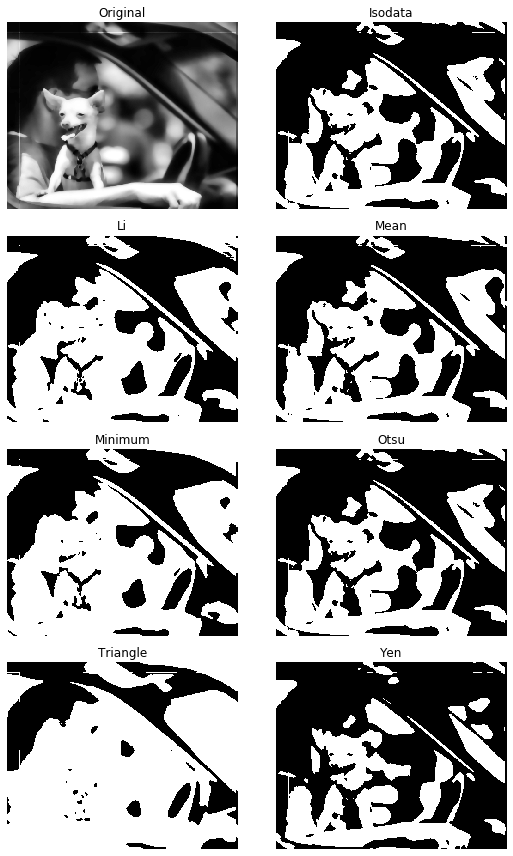

In [128]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(gray_img_eq, figsize=(8, 12), verbose=False)
plt.show()

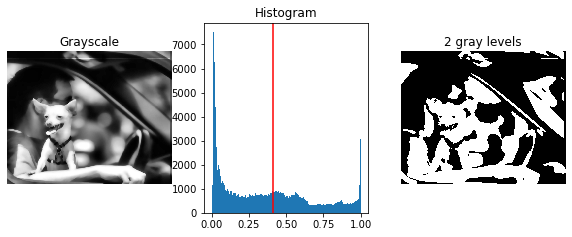

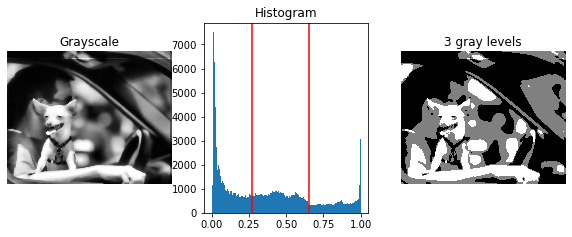

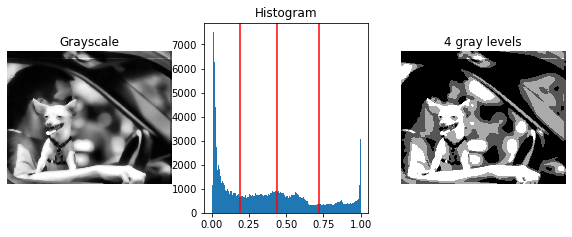

In [133]:
classes = [2, 3, 4]
for cl in classes:
    transform_image(gray_img_eq, cl)

In [132]:
def transform_image(original, classes=3, cmap_result='gray'):
    thresholds = threshold_multiotsu(original, classes=classes)
    regions = np.digitize(original, bins=thresholds)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Grayscale')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(original.ravel(), bins=255)
    ax[1].set_title('Histogram')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap=cmap_result)
    ax[2].set_title(str(classes) + ' gray levels')
    ax[2].axis('off')

    plt.subplots_adjust()

    plt.show()


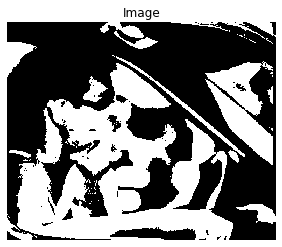

In [61]:
thresholds = threshold_multiotsu(gray_img_eq, classes=2)
gray_img_eq_3 = np.digitize(gray_img_eq, bins=thresholds)
show_image(gray_img_eq_3)

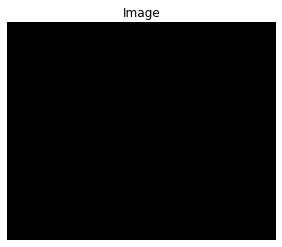

In [65]:
canny_edges = canny(gray_img_eq_3, sigma=0.5)
show_image(canny_edges)

In [54]:
show_image(contours)

TypeError: Image data of dtype object cannot be converted to float